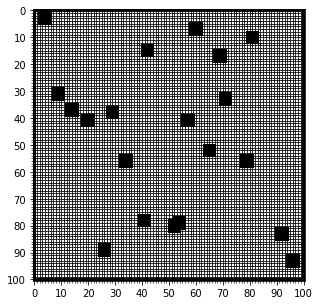

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from matplotlib.ticker import FixedLocator
from PIL import Image
import os
import yaml

def create_yaml_files(map_name,origin):
    map_yaml = {
        "image": "{0}.png".format(map_name),
        "resolution": 0.5,
        "origin": [0.0,0.0,0.0], # [-x,-y,0.0]
        "negate": 0,
        "occupied_thresh": 0.65,
        "free_thresh": 0.196}
    with open("{}/map.yaml".format(map_name), 'w') as outfile:
        yaml.dump(map_yaml, outfile, sort_keys=False,default_flow_style=None)
    world_yaml_properties = {"properties":{"velocity_iterations": 10,"position_iterations": 10}}
    world_yaml_layers = {"layers":[{"name": "static","map": "map.yaml","color": [0, 1, 0, 1]}]}
    with open("{}/map.world.yaml".format(map_name), 'w') as outfile:
        yaml.dump(world_yaml_properties, outfile, sort_keys=False,default_flow_style=False) # somehow the first part must be with default_flow_style=False
        yaml.dump(world_yaml_layers, outfile, sort_keys=False,default_flow_style=None) # 2nd part must be with default_flow_style=None

def make_image_for_human(map,map_name): # create human-aestethic PNG file from occupancy map (1:occupied, 0:free)
    height = map.shape[0] 
    width = map.shape[1]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(map, cmap='binary', interpolation='none') # heatmap, interpolation "none" image scaling big->small, "nearest" small->big
    plt.axis("on")
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)   
    ax.set_xticks(range(0,width,10))
    ax.set_xticklabels(range(0,width,10))
    ax.set_yticks(range(0,height,10))
    ax.set_yticklabels(range(0,height,10))
    ax.xaxis.set_minor_locator(FixedLocator(range(0,width,1)))
    ax.yaxis.set_minor_locator(FixedLocator(range(0,height,1)))
    plt.grid("on",which="both",color="black")
    plt.savefig("{0}/{0}_human.png".format(map_name), bbox_inches='tight') 

def make_image(map): # create PNG file from occupancy map (1:occupied, 0:free) and 
    now = datetime.datetime.now()
    img = Image.fromarray(((map-1)**2*255).astype('uint8')) # monochromatic image
    imgrgb = img.convert('RGB')
    map_name = "map_{}".format(now.strftime("%Y_%m_%d_%H_%M_%S")) # create mapname from current datetime
    os.mkdir(map_name) # create directory based on mapname
    imgrgb.save("{0}/{0}.png".format(map_name)) # save map in map directory
    create_yaml_files(map_name) # create corresponding yaml files
    make_image_for_human(map,map_name) # 
 

def initialize_map(height,width,type="indoor"): # create empty map with format given by height,width and initialize empty tree
    if type == "outdoor":
        map = np.tile(1,[height,width])
        map[slice(1,height-1),slice(1,width-1)] = 0
        return map
    else:
        return np.tile(1,[height,width])

def insert_root_node(map,tree): # create root node in center of map
    root_node = [int(np.floor(map.shape[0]/2)),int(np.floor(map.shape[1]/2))]
    map[root_node[0],root_node[1]] = 0
    tree.append(root_node)

def sample(map,corridor_radius): # sample position from map within boundary and leave tolerance for corridor width
    random_x = np.random.choice(range(corridor_radius+1,map.shape[0]-corridor_radius,1))
    random_y = np.random.choice(range(corridor_radius+1,map.shape[1]-corridor_radius,1))
    return [random_x,random_y]

def find_nearest_node(random_position,tree): # find nearest node according to L1 norm
    nearest_node = []
    min_distance = np.inf
    for node in tree:
        distance = sum(np.abs(np.array(random_position)-np.array(node)))
        if distance < min_distance:
            min_distance = distance
            nearest_node = node
    return nearest_node

def insert_new_node(random_position,tree,map): # insert new node into the map and tree
    map[random_position[0],random_position[1]] = 0
    tree.append(random_position)

def get_constellation(node1,node2):
    # there are two relevant constellations for the 2 nodes, which must be considered when creating the horizontal and vertical path
    # 1: lower left and upper right
    # 2: upper left and lower right
    # each of the 2 constellation have 2 permutations which must be considered as well    
    constellation1 = {
        "permutation1": node1[0]>node2[0] and node1[1]<node2[1], # x1>x2 and y1<y2
        "permutation2": node1[0]<node2[0] and node1[1]>node2[1]} # x1<x2 and y1>y2
    if constellation1["permutation1"] or constellation1["permutation2"]:
        return 1 
    else:
        return 2

def create_path(node1,node2,corridor_radius,map):
    coin_flip = np.random.random()
    x1,x2 = sorted([node1[0],node2[0]]) # x and y coordinates must be sorted for usage with range function
    y1,y2 = sorted([node1[1],node2[1]])
    if get_constellation(node1,node2)==1: # check which constellation
        if coin_flip>=0.5: # randomly determine the curvature of the path (right turn/left turn)
            map[slice(x1-corridor_radius,x1+corridor_radius+1),range(y1-corridor_radius,y2+1+corridor_radius,1)] = 0 # horizontal path
            map[range(x1-corridor_radius,x2+1+corridor_radius,1),slice(y1-corridor_radius,y1+corridor_radius+1)] = 0 # vertical path
        else:
            map[slice(x2-corridor_radius,x2+corridor_radius+1),range(y1-corridor_radius,y2+1+corridor_radius,1)] = 0 # horizontal path
            map[range(x1-corridor_radius,x2+1+corridor_radius,1),slice(y2-corridor_radius,y2+corridor_radius+1)] = 0 # vertical path
    else:
        if coin_flip>=0.5: # randomly determine the curvature of the path (right turn/left turn)
            map[slice(x1-corridor_radius,x1+corridor_radius+1),range(y1-corridor_radius,y2+1+corridor_radius,1)] = 0 # horizontal path
            map[range(x1-corridor_radius,x2+1+corridor_radius,1),slice(y2-corridor_radius,y2+corridor_radius+1)] = 0 # vertical path
        else:
            map[slice(x2-corridor_radius,x2+corridor_radius+1),range(y1-corridor_radius,y2+1+corridor_radius,1)] = 0 # horizontal path
            map[range(x1-corridor_radius,x2+1+corridor_radius,1),slice(y1-corridor_radius,y1+corridor_radius+1)] = 0 # vertical path

def create_indoor_map(height,width,corridor_radius,iterations):
    tree = [] # initialize empty tree
    map = initialize_map(height,width)
    insert_root_node(map,tree)
    for i in range(iterations): # create as many paths/nodes as defined in iteration
        random_position = sample(map,corridor_radius)
        nearest_node = find_nearest_node(random_position,tree) # nearest node must be found before inserting the new node into the tree, else nearest node will be itself
        insert_new_node(random_position,tree,map)
        create_path(random_position,nearest_node,corridor_radius,map)
    return map

def create_outdoor_map(height,width,obstacle_number,obstacle_extra_radius):
    map = initialize_map(height,width,type="outdoor")
    for i in range(obstacle_number):
        random_position = sample(map,obstacle_extra_radius) 
        map[slice(random_position[0]-obstacle_extra_radius,random_position[0]+obstacle_extra_radius+1), # create 1 pixel obstacles with extra radius if specified
        slice(random_position[1]-obstacle_extra_radius,random_position[1]+obstacle_extra_radius+1)] = 1
    return map


### main function ###
indoor_map = create_indoor_map(
    height = 101,
    width = 101,
    corridor_radius = 3,
    iterations = 100
)

outdoor_map = create_outdoor_map(
    height = 101,
    width = 101,
    obstacle_number = 20,
    obstacle_extra_radius = 2 # extra radius, obstacle_extra_radius=0 equals 1 pixel obstacles
)

make_image(outdoor_map)

In [77]:
a = np.random.random([5,5])
a[slice(1,4),slice(0,4)] = 0
a[slice(-1,2)] = 1
a

array([[0.50053272, 0.29183094, 0.23498249, 0.03121873, 0.69717954],
       [0.        , 0.        , 0.        , 0.        , 0.71652223],
       [0.        , 0.        , 0.        , 0.        , 0.16629119],
       [0.        , 0.        , 0.        , 0.        , 0.56556777],
       [0.20523002, 0.09504156, 0.66491402, 0.68220701, 0.41034832]])

In [60]:
np.random.random()

0.08279751817131287

In [9]:
np.tile(80.0,[5,10]).size*100

5000

In [29]:
dict = {"origin":[[0.0,0.0,0.0]]}
print(yaml.safe_dump(dict))

origin:
- - 0.0
  - 0.0
  - 0.0



In [11]:
    world_yaml = {"properties": {"velocity_iterations": 10.0,"position_iterations": 10.0}}
    # with open("{}/map.world.yaml".format(map_name), 'w') as outfile:
    print(yaml.dump(world_yaml, sort_keys=False))

properties:
  velocity_iterations: 10.0
  position_iterations: 10.0



In [ ]:
,
        "layers":{"name": "static","map": "map.yaml","color": [0, 1, 0, 1]}
        default_flow_style=None